<a href="https://colab.research.google.com/github/skaumbdoallsaws-coder/AI-Drawing-Inspector/blob/main/ai_inspector_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Engineering Drawing Inspector v2.0

**Single-File QC Pipeline**

Outputs:
1. `ResolvedPartIdentity.json`
2. `DrawingEvidence.json`
3. `DiffResult.json`
4. `QCReport.md`

In [1]:
# Cell 1: Install Dependencies
!pip install -q pymupdf opencv-python-headless jsonschema pillow pytesseract
!pip install -q accelerate qwen-vl-utils bitsandbytes
!pip install -q git+https://github.com/huggingface/transformers
!apt-get install -y poppler-utils tesseract-ocr > /dev/null 2>&1
print("Dependencies installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 63.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 11.0 MB/s eta 0:00:00
Dependencies installed!


In [2]:
# Cell 2: Imports and Configuration
import os, json, re, gc
import torch
import fitz
import numpy as np
from PIL import Image
from pathlib import Path
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime

# Configuration
DRAWING_PDF_PATH = ""
SOLIDWORKS_JSON_DIR = "sw_json_library"
OUTPUT_DIR = "qc_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch: 2.9.0+cu126
CUDA: True


In [3]:
# Cell 3: BOM-Robust JSON Loader
def load_json_robust(filepath) -> Tuple[Optional[Dict], Optional[str]]:
    """Load JSON with BOM handling. Tries: utf-8-sig, utf-8, latin-1"""
    filepath = Path(filepath)
    for enc in ['utf-8-sig', 'utf-8', 'latin-1']:
        try:
            with open(filepath, 'r', encoding=enc) as f:
                return json.load(f), None
        except UnicodeDecodeError:
            continue
        except json.JSONDecodeError as e:
            if 'BOM' in str(e) and enc == 'utf-8':
                continue
            return None, f"JSON error: {str(e)[:50]}"
        except Exception as e:
            return None, f"Error: {str(e)[:50]}"
    return None, "Failed all encodings"

print("load_json_robust defined")

load_json_robust defined


In [4]:
# Cell 4: PDF Rendering
@dataclass
class PageArtifact:
    pageIndex0: int
    page: int
    image: Image.Image
    width: int
    height: int
    dpi: int
    direct_text: Optional[str] = None

def render_pdf(pdf_path: str, dpi: int = 300) -> List[PageArtifact]:
    """Render first page of PDF to image."""
    artifacts = []
    doc = fitz.open(pdf_path)
    page = doc.load_page(0)
    zoom = dpi / 72.0
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), alpha=False)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    direct_text = page.get_text("text")

    artifacts.append(PageArtifact(
        pageIndex0=0, page=1, image=img,
        width=pix.width, height=pix.height, dpi=dpi,
        direct_text=direct_text if len(direct_text.strip()) > 10 else None
    ))
    doc.close()
    print(f"Rendered: {pix.width}x{pix.height}px")
    return artifacts

print("render_pdf defined")

render_pdf defined


In [5]:
# Cell 5: SolidWorks JSON Library
@dataclass
class SwPartEntry:
    json_path: str
    part_number: str
    filename_stem: str = ""
    data: Dict[str, Any] = field(default_factory=dict)

class SwJsonLibrary:
    def __init__(self):
        self.by_part_number: Dict[str, SwPartEntry] = {}
        self.by_filename: Dict[str, SwPartEntry] = {}
        self.all_entries: List[SwPartEntry] = []

    def _normalize(self, s: str) -> str:
        return re.sub(r'[-\s_]', '', str(s or '')).lower()

    def load_from_directory(self, directory: str):
        json_files = list(Path(directory).glob("**/*.json"))
        print(f"Found {len(json_files)} JSON files")

        for jp in json_files:
            data, err = load_json_robust(jp)
            if data is None:
                continue
            pn = data.get('identity', {}).get('partNumber', '')
            entry = SwPartEntry(str(jp), pn, jp.stem, data)
            self.all_entries.append(entry)
            if pn:
                self.by_part_number[pn] = entry
                self.by_part_number[self._normalize(pn)] = entry
            self.by_filename[jp.stem] = entry
            self.by_filename[self._normalize(jp.stem)] = entry
        print(f"Loaded {len(self.all_entries)} files")

    def lookup(self, candidate: str) -> Optional[SwPartEntry]:
        if not candidate:
            return None
        norm = self._normalize(candidate)
        return self.by_part_number.get(candidate) or self.by_part_number.get(norm) or \
               self.by_filename.get(candidate) or self.by_filename.get(norm)

sw_library = SwJsonLibrary()
print("SwJsonLibrary defined")

SwJsonLibrary defined


In [6]:
# Cell 6: Part Identity Resolution (Robust Matching)

@dataclass
class ResolvedPartIdentity:
    partNumber: str
    confidence: float
    source: str
    swJsonPath: Optional[str] = None
    candidates_tried: List[str] = field(default_factory=list)

def clean_filename(filename: str) -> str:
    """Remove known suffixes like Paint, REV, etc."""
    cleaned = re.sub(r'[\s_]*(Paint|PAINT)$', '', filename, flags=re.IGNORECASE)
    return cleaned.strip()

def extract_pn_candidates(filename: str) -> List[str]:
    """
    Extract potential part number candidates from filename.
    Handles: 1013572_01, 101357201-03, 314884W_0, 046-935-REV-A
    Returns list of candidates (most specific to least).
    """
    name_no_ext = os.path.splitext(filename)[0]
    # Remove duplicate markers like (1), (2)
    name_no_ext = re.sub(r'\s*\(\d+\)$', '', name_no_ext)
    cleaned = clean_filename(name_no_ext)
    parts = re.split(r'[\s_]+', cleaned)

    if not parts:
        return []

    base = parts[0]
    candidates = []

    # 1. Base as-is
    candidates.append(base)

    # 2. Without hyphens
    base_no_hyphen = base.replace('-', '')
    if base_no_hyphen != base:
        candidates.append(base_no_hyphen)

    # 3. Remove letter suffixes (046-935A -> 046-935)
    if base and base[-1].isalpha() and len(base) > 1:
        candidates.append(base[:-1])
        candidates.append(base[:-1].replace('-', ''))

    # 4. Handle revision pattern (046-935-01 -> 046-935)
    rev_match = re.match(r'^(.+)-(\d{1,2})$', base)
    if rev_match:
        main_part = rev_match.group(1)
        candidates.append(main_part)
        candidates.append(main_part.replace('-', ''))

    # 5. Handle REV suffix (046-935-REV-A -> 046-935)
    rev_alpha = re.match(r'^(.+?)[-_]?REV[-_]?[A-Z0-9]*$', base, re.IGNORECASE)
    if rev_alpha:
        candidates.append(rev_alpha.group(1))
        candidates.append(rev_alpha.group(1).replace('-', ''))

    # 6. Peeling - progressively remove trailing digits
    temp = base_no_hyphen
    while len(temp) > 5:
        temp = temp[:-1]
        candidates.append(temp)

    # Remove duplicates, preserve order
    seen = set()
    unique = []
    for c in candidates:
        if c and c not in seen:
            seen.add(c)
            unique.append(c)

    return unique

def resolve_part_identity(pdf_path: str, artifacts: List[PageArtifact], sw_lib: SwJsonLibrary) -> ResolvedPartIdentity:
    """Resolve part identity using robust filename matching."""
    filename = os.path.basename(pdf_path)
    candidates = extract_pn_candidates(filename)

    # Try each candidate against SW library
    for candidate in candidates:
        entry = sw_lib.lookup(candidate)
        if entry:
            return ResolvedPartIdentity(
                partNumber=entry.part_number or candidate,
                confidence=1.0,
                source="filename+sw",
                swJsonPath=entry.json_path,
                candidates_tried=candidates
            )

    # Try PDF embedded text
    for art in artifacts:
        if art.direct_text:
            text_candidates = extract_pn_candidates(art.direct_text[:200])
            for candidate in text_candidates[:5]:
                entry = sw_lib.lookup(candidate)
                if entry:
                    return ResolvedPartIdentity(
                        partNumber=entry.part_number or candidate,
                        confidence=0.8,
                        source="pdf_text+sw",
                        swJsonPath=entry.json_path,
                        candidates_tried=candidates + text_candidates[:5]
                    )

    # Fallback - use first candidate or filename stem
    fallback_pn = candidates[0] if candidates else Path(pdf_path).stem
    return ResolvedPartIdentity(
        partNumber=fallback_pn,
        confidence=0.3,
        source="fallback",
        swJsonPath=None,
        candidates_tried=candidates
    )

print("resolve_part_identity defined (robust matching)")

resolve_part_identity defined (robust matching)


In [7]:
# Cell 7: Load SolidWorks Library (Upload ZIP)
from google.colab import files
import zipfile

if not os.path.exists(SOLIDWORKS_JSON_DIR) or not list(Path(SOLIDWORKS_JSON_DIR).glob("*.json")):
    print("Upload your sw_json_library.zip file:")
    uploaded = files.upload()

    for filename in uploaded:
        if filename.endswith('.zip'):
            print(f"Extracting {filename}...")
            with zipfile.ZipFile(filename, 'r') as z:
                z.extractall(SOLIDWORKS_JSON_DIR)
            print(f"Extracted to {SOLIDWORKS_JSON_DIR}")
            break

sw_library.load_from_directory(SOLIDWORKS_JSON_DIR)
print(f"Library ready: {len(sw_library.all_entries)} parts indexed")

Upload your sw_json_library.zip file:


Saving sw_json_library.zip to sw_json_library.zip
Extracting sw_json_library.zip...
Extracted to sw_json_library
Found 381 JSON files
Loaded 381 files
Library ready: 381 parts indexed


Upload your PDF drawing:


Saving 101357301_00.PDF to 101357301_00.PDF
Processing: 101357301_00.PDF
Rendered: 5100x3300px


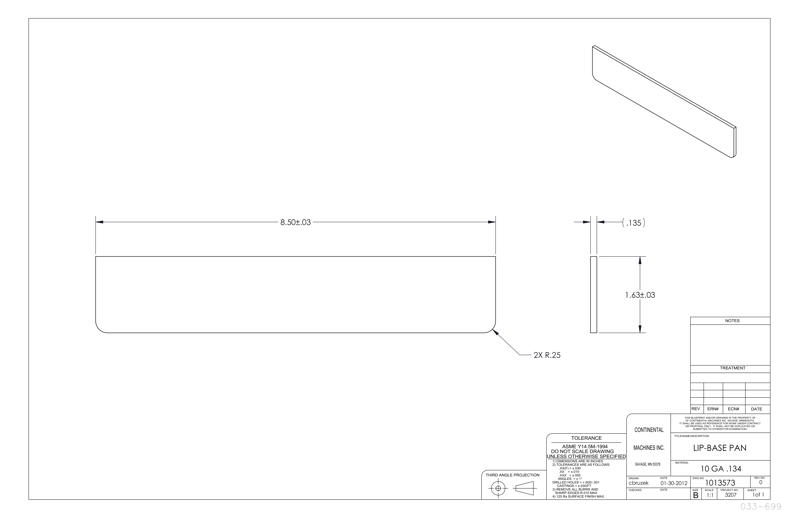

In [8]:
# Cell 8: Upload and Render PDF Drawing
from google.colab import files
from IPython.display import display

print("Upload your PDF drawing:")
uploaded = files.upload()

for filename in uploaded:
    if filename.lower().endswith('.pdf'):
        DRAWING_PDF_PATH = filename
        break

print(f"Processing: {DRAWING_PDF_PATH}")
artifacts = render_pdf(DRAWING_PDF_PATH)

# Display the rendered image
if artifacts:
    display(artifacts[0].image.resize((800, int(800 * artifacts[0].height / artifacts[0].width))))

In [9]:
# Cell 9: Resolve Part Identity
part_identity = resolve_part_identity(DRAWING_PDF_PATH, artifacts, sw_library)

print("="*50)
print("RESOLVED PART IDENTITY")
print("="*50)
print(f"Part Number:  {part_identity.partNumber}")
print(f"Confidence:   {part_identity.confidence}")
print(f"Source:       {part_identity.source}")
print(f"SW JSON:      {part_identity.swJsonPath or 'Not found'}")
print(f"Candidates:   {part_identity.candidates_tried[:5]}")

# Save to output
identity_out = os.path.join(OUTPUT_DIR, "ResolvedPartIdentity.json")
with open(identity_out, 'w') as f:
    json.dump(asdict(part_identity), f, indent=2)
print(f"\nSaved: {identity_out}")

RESOLVED PART IDENTITY
Part Number:  1013573
Confidence:   1.0
Source:       filename+sw
SW JSON:      sw_json_library/1013573.json
Candidates:   ['101357301', '10135730', '1013573', '101357', '10135']

Saved: qc_output/ResolvedPartIdentity.json


In [ ]:
# Cell 10: Load LightOnOCR-2 and Run OCR
from transformers import LightOnOcrForConditionalGeneration, LightOnOcrProcessor
from google.colab import userdata

# Clear GPU memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Get HF token
try:
    hf_token = userdata.get('HF_TOKEN')
except:
    hf_token = None

print("Loading LightOnOCR-2-1B...")
ocr_device = "cuda" if torch.cuda.is_available() else "cpu"
ocr_dtype = torch.bfloat16 if ocr_device == "cuda" else torch.float32

ocr_processor = LightOnOcrProcessor.from_pretrained(
    "lightonai/LightOnOCR-2-1B",
    token=hf_token
)

ocr_model = LightOnOcrForConditionalGeneration.from_pretrained(
    "lightonai/LightOnOCR-2-1B",
    torch_dtype=ocr_dtype,
    token=hf_token
).to(ocr_device)

print(f"LightOnOCR-2 loaded: {ocr_model.get_memory_footprint() / 1e9:.2f} GB")

def run_lighton_ocr(image: Image.Image) -> List[str]:
    """Run LightOnOCR-2 on image, return list of text lines."""
    global ocr_model, ocr_processor, ocr_device, ocr_dtype

    img = image.convert("RGB")
    conversation = [{"role": "user", "content": [{"type": "image", "image": img}]}]

    inputs = ocr_processor.apply_chat_template(
        conversation, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    )
    inputs = {k: v.to(device=ocr_device, dtype=ocr_dtype) if v.is_floating_point() else v.to(ocr_device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = ocr_model.generate(**inputs, max_new_tokens=2048)

    generated_ids = output_ids[0, inputs["input_ids"].shape[1]:]
    output_text = ocr_processor.decode(generated_ids, skip_special_tokens=True)

    return [line.strip() for line in output_text.split("\n") if line.strip()]

# Run OCR on the drawing
print("Running OCR on drawing...")
ocr_lines = run_lighton_ocr(artifacts[0].image)
print(f"OCR extracted {len(ocr_lines)} lines")
print("\nFirst 10 lines:")
for line in ocr_lines[:10]:
    print(f"  {line}")

In [ ]:
# Cell 11: Parse OCR to JSON Callouts

# Regex patterns for extracting callouts
PATTERNS = {
    # Metric threads: M10x1.5, M6X1.0
    'metric_thread': r'M(\d+(?:\.\d+)?)\s*[xX]\s*(\d+(?:\.\d+)?)',
    # Imperial threads: 1/2-13, 3/8-16
    'imperial_thread': r'(\d+/\d+)\s*-\s*(\d+)',
    # Through holes: o12.70 THRU, DIA 0.500 THRU
    'thru_hole': r'[oOØ∅]?\s*(\d+\.?\d*)\s*(?:mm|MM)?\s*THRU',
    # Blind holes: o12.70 x 25 DEEP
    'blind_hole': r'[oOØ∅]?\s*(\d+\.?\d*)\s*[xX]\s*(\d+\.?\d*)\s*(?:DEEP|DP)',
    # Dimensions with tolerance: 25.4 ±0.05
    'dim_tolerance': r'(\d+\.?\d*)\s*[±]\s*(\d+\.?\d*)',
    # Counterbore: CBORE or counterbore
    'counterbore': r'(?:CBORE|C\'BORE|COUNTERBORE)\s*[oOØ∅]?\s*(\d+\.?\d*)',
    # Countersink: CSK or countersink
    'countersink': r'(?:CSK|C\'SINK|COUNTERSINK)\s*(\d+\.?\d*)\s*[°]?',
    # Fillet radius: R3, R0.5
    'fillet': r'\bR(\d+\.?\d*)\b',
    # Chamfer: 0.5 X 45, 1x45
    'chamfer': r'(\d+\.?\d*)\s*[xX]\s*45\s*[°]?',
    # Quantity: 4X, 2 PLCS, (3X)
    'quantity': r'[(\s]?(\d+)\s*[xX)\s]|(\d+)\s*PL(?:CS?|ACES?)',
}

def parse_ocr_to_callouts(ocr_lines: List[str]) -> Dict[str, Any]:
    """Parse OCR text lines into structured callouts."""
    callouts = []
    raw_text = "\n".join(ocr_lines)
    text_upper = raw_text.upper()
    
    # Extract metric threads
    for match in re.finditer(PATTERNS['metric_thread'], text_upper):
        callouts.append({
            'calloutType': 'TappedHole',
            'thread': {
                'standard': 'Metric',
                'nominalDiameterMm': float(match.group(1)),
                'pitch': float(match.group(2))
            },
            'raw': match.group(0)
        })
    
    # Extract imperial threads
    for match in re.finditer(PATTERNS['imperial_thread'], text_upper):
        callouts.append({
            'calloutType': 'TappedHole',
            'thread': {
                'standard': 'Imperial',
                'size': match.group(1),
                'tpi': int(match.group(2))
            },
            'raw': match.group(0)
        })
    
    # Extract through holes
    for match in re.finditer(PATTERNS['thru_hole'], text_upper):
        callouts.append({
            'calloutType': 'Hole',
            'diameterMm': float(match.group(1)),
            'isThrough': True,
            'raw': match.group(0)
        })
    
    # Extract blind holes
    for match in re.finditer(PATTERNS['blind_hole'], text_upper):
        callouts.append({
            'calloutType': 'Hole',
            'diameterMm': float(match.group(1)),
            'depthMm': float(match.group(2)),
            'isThrough': False,
            'raw': match.group(0)
        })
    
    # Extract fillets
    for match in re.finditer(PATTERNS['fillet'], text_upper):
        callouts.append({
            'calloutType': 'Fillet',
            'radiusMm': float(match.group(1)),
            'raw': match.group(0)
        })
    
    # Extract chamfers
    for match in re.finditer(PATTERNS['chamfer'], text_upper):
        callouts.append({
            'calloutType': 'Chamfer',
            'distance1Mm': float(match.group(1)),
            'angleDegrees': 45,
            'raw': match.group(0)
        })
    
    # Build evidence document
    evidence = {
        'schemaVersion': '1.1.1',
        'partNumber': part_identity.partNumber,
        'extractedAt': datetime.utcnow().isoformat() + 'Z',
        'ocrLineCount': len(ocr_lines),
        'foundCallouts': callouts,
        'rawOcrSample': ocr_lines[:20]
    }
    
    return evidence

# Parse and display
evidence = parse_ocr_to_callouts(ocr_lines)

print("="*50)
print("DRAWING EVIDENCE")
print("="*50)
print(f"Callouts found: {len(evidence['foundCallouts'])}")
for c in evidence['foundCallouts'][:10]:
    print(f"  {c['calloutType']}: {c.get('raw', '')}")

# Save to output
evidence_out = os.path.join(OUTPUT_DIR, "DrawingEvidence.json")
with open(evidence_out, 'w') as f:
    json.dump(evidence, f, indent=2)
print(f"\nSaved: {evidence_out}")

In [ ]:
# Cell 12: Generate DiffResult (Compare Drawing vs SolidWorks)

def extract_sw_requirements(sw_data: Dict) -> List[Dict]:
    """Extract requirements from SolidWorks JSON."""
    requirements = []
    
    # Extract from features
    features = sw_data.get('features', {})
    
    # Tapped holes
    for hole in features.get('tappedHoles', []):
        requirements.append({
            'type': 'TappedHole',
            'thread': hole.get('thread', {}),
            'source': 'sw_features'
        })
    
    # Plain holes
    for hole in features.get('plainHoles', []):
        requirements.append({
            'type': 'Hole',
            'diameterMm': hole.get('diameter'),
            'depthMm': hole.get('depth'),
            'isThrough': hole.get('isThrough', False),
            'source': 'sw_features'
        })
    
    # Fillets
    for fillet in features.get('fillets', []):
        requirements.append({
            'type': 'Fillet',
            'radiusMm': fillet.get('radius'),
            'source': 'sw_features'
        })
    
    # Chamfers
    for chamfer in features.get('chamfers', []):
        requirements.append({
            'type': 'Chamfer',
            'distance1Mm': chamfer.get('distance1'),
            'angleDegrees': chamfer.get('angle', 45),
            'source': 'sw_features'
        })
    
    return requirements

def compare_callout_to_requirement(callout: Dict, req: Dict, tolerance: float = 0.15) -> bool:
    """Check if a drawing callout matches a SW requirement."""
    if callout.get('calloutType') != req.get('type'):
        return False
    
    ctype = callout.get('calloutType')
    
    if ctype == 'Hole':
        d1 = callout.get('diameterMm', 0)
        d2 = req.get('diameterMm', 0)
        if d1 and d2 and abs(d1 - d2) <= tolerance:
            return True
    
    elif ctype == 'TappedHole':
        t1 = callout.get('thread', {})
        t2 = req.get('thread', {})
        if t1.get('nominalDiameterMm') == t2.get('nominalDiameterMm'):
            return True
    
    elif ctype == 'Fillet':
        r1 = callout.get('radiusMm', 0)
        r2 = req.get('radiusMm', 0)
        if r1 and r2 and abs(r1 - r2) <= tolerance:
            return True
    
    elif ctype == 'Chamfer':
        d1 = callout.get('distance1Mm', 0)
        d2 = req.get('distance1Mm', 0)
        if d1 and d2 and abs(d1 - d2) <= tolerance:
            return True
    
    return False

def generate_diff_result(evidence: Dict, sw_data: Dict) -> Dict:
    """Compare drawing evidence against SolidWorks requirements."""
    callouts = evidence.get('foundCallouts', [])
    requirements = extract_sw_requirements(sw_data)
    
    found = []
    missing = []
    matched_callouts = set()
    
    # Check each requirement
    for req in requirements:
        match_found = False
        for i, callout in enumerate(callouts):
            if i not in matched_callouts and compare_callout_to_requirement(callout, req):
                found.append({
                    'status': 'FOUND',
                    'requirement': req,
                    'evidence': callout
                })
                matched_callouts.add(i)
                match_found = True
                break
        
        if not match_found:
            missing.append({
                'status': 'MISSING',
                'requirement': req,
                'evidence': None
            })
    
    # Extra callouts not matched to any requirement
    extra = []
    for i, callout in enumerate(callouts):
        if i not in matched_callouts:
            extra.append({
                'status': 'EXTRA',
                'requirement': None,
                'evidence': callout
            })
    
    diff_result = {
        'partNumber': evidence.get('partNumber'),
        'generatedAt': datetime.utcnow().isoformat() + 'Z',
        'summary': {
            'totalRequirements': len(requirements),
            'found': len(found),
            'missing': len(missing),
            'extra': len(extra)
        },
        'details': {
            'found': found,
            'missing': missing,
            'extra': extra
        }
    }
    
    return diff_result

# Load SW data and generate diff
if part_identity.swJsonPath:
    sw_data, err = load_json_robust(part_identity.swJsonPath)
    if sw_data:
        diff_result = generate_diff_result(evidence, sw_data)
        
        print("="*50)
        print("DIFF RESULT")
        print("="*50)
        print(f"Part: {diff_result['partNumber']}")
        print(f"  FOUND:   {diff_result['summary']['found']}")
        print(f"  MISSING: {diff_result['summary']['missing']}")
        print(f"  EXTRA:   {diff_result['summary']['extra']}")
        
        # Save
        diff_out = os.path.join(OUTPUT_DIR, "DiffResult.json")
        with open(diff_out, 'w') as f:
            json.dump(diff_result, f, indent=2)
        print(f"\nSaved: {diff_out}")
    else:
        print(f"Error loading SW JSON: {err}")
else:
    print("No SW JSON path - cannot generate diff")